# MSDS 460 Term Project

This notebook will show the code used to model my term project, aimed at using mixed-integer programming to optimize scheduling for a neuroimaging research study.

## Goal

The goal of my project is to optimize scheduling for a neuroimaging research study that uses multimodal imaging scans on 24 participants. Each participant is required to get an MRI scan, an amyloid PET scan, and a Tau PET scan within a single calendar year. Each scanning facility has hard constraints, detailed below:

* MRI facility - 90-minute scanning sessions from M-F 8:30am-4:30pm
* PET facility - 2 scanning sessions in the afternoon from T-F 4:30pm-5:00pm and 5:00pm-5:30pm

Additionally, to ensure patient safety, a biologic constraint of the PET scans is that they cannot occur on the same day and **MUST** be done at least 24 hours apart. One of the PET scans can be scheduled Tuesdays-Thursdays, and the other PET scan can only be scheduled on Thursday due to manufacturing constraints. Lastly, all three scans must be completed within a 6-month window.

In [4]:
# Import libraries
import pandas as pd
import numpy as np
!pip install pulp
from pulp import LpProblem, LpVariable, LpMinimize, value, LpStatus, LpBinary, LpInteger, lpSum, PULP_CBC_CMD
from datetime import datetime, timedelta
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Set up notebook to display multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.5 MB/s eta 0:00:00


In [5]:
# Create data needed (simulated)
# Patient list
patients = [f"P{str(i).zfill(3)}" for i in range(1, 25)]

# Scan list
scan_types = ['MRI', 'Amyloid', 'Tau']

# Define days available
all_days = pd.date_range(start="2025-01-01", end="2025-12-31", freq='B')  # Business days only
days = [d.strftime('%Y-%m-%d') for d in all_days]
M = len(days)  # e.g., 261 business days in 2025

# Scan availability configuration
scan_availability = {
    "MRI": {
        "days": [d for d in days if pd.to_datetime(d).weekday() < 5],  # Mon–Fri
        "slots": [f"{h:02d}:{m:02d}" for h in range(8, 16) for m in [30, 0]],
    },
    "Amyloid": {
        "days": [d for d in days if pd.to_datetime(d).weekday() in [1, 2, 3]],  # Tue–Thurs
        "slots": ["16:30", "17:00"]
    },
    "Tau": {
        "days": [d for d in days if pd.to_datetime(d).weekday() == 3],  # Thu only
        "slots": ["16:30", "17:00"]
    }
}

# Map day string to integer index
date_list = sorted(all_days)
date_to_idx = {d.strftime('%Y-%m-%d'): i for i, d in enumerate(date_list)}
days = [d for d in days if d in date_to_idx]

In [6]:
# Define the model
model = LpProblem("Patient_scheduling", LpMinimize)

In [7]:
# Determine decision variables
# x[p,s,d,t] = assign 1 if patient p gets scan s slot on day d at time t
x = LpVariable.dicts(
    "scan_assign",
    ((p, s, d, t) 
     for p in patients 
     for s in scan_types 
     for d in scan_availability[s]["days"] 
     for t in scan_availability[s]["slots"]),
    cat="Binary"
)

# y[p,d] = assign 1 if patient p gets scan on day d
y = LpVariable.dicts(
    "scan_day",
    ((p, d) 
     for p in patients 
     for d in days),
    cat="Binary"
)

# Earliest/latest binary variables (only for days where y could be 1)
u = LpVariable.dicts(
    "u_earliest",
    ((p,d) for p in patients for d in days),
    cat="Binary"
)
v = LpVariable.dicts(
    "v_latest",
    ((p,d) for p in patients for d in days),
    cat="Binary"
)

# Continuous Earliest/Latest integer indices
Earliest = LpVariable.dicts("Earliest_idx", patients, lowBound=0, upBound=M-1, cat="Integer")
Latest = LpVariable.dicts("Latest_idx", patients, lowBound=0, upBound=M-1, cat="Integer")

In [8]:
# Define objective function: Minimize total scan days per patient
model += lpSum(y[p, d] for p in patients for d in days)

In [9]:
# Set up constraints

# Constraint 1: Each patient must receive one scan of each type
for p in patients:
    for s in scan_types:
        model += lpSum(x[p, s, d, t] for d in scan_availability[s]["days"]
                      for t in scan_availability[s]["slots"]) == 1

# Constraint 2: If a patient has any scan on a day, mark it in y[p, d]
for p in patients:
    for d in days:
        scans_today = [x[p, s, d, t] for s in scan_types if d in scan_availability[s]["days"] for t in scan_availability[s]["slots"]]
        if scans_today:
            model += y[p, d] <= lpSum(scans_today)
            model += y[p, d] * len(scans_today) >= lpSum(scans_today)
        else:
            model += y[p, d] == 0

# Constraint 3: No scan time slot can be used more than once
for s in scan_types:
    for d in scan_availability[s]["days"]:
        for t in scan_availability[s]["slots"]:
            model += lpSum(x[p, s, d, t] for p in patients) <= 1

# Constraint 4: Amyloid and Tau scans cannot be on same date for same patient
for p in patients:
    for d in days:
        if d in scan_availability["Amyloid"]["days"] and d in scan_availability["Tau"]["days"]:
            model += (lpSum(x[p, "Amyloid", d, t] for t in scan_availability["Amyloid"]["slots"]) +
                     lpSum(x[p, "Tau", d, t] for t in scan_availability["Tau"]["slots"])
                     ) <= 1

# Constraint 5: 6 month scan window for patients
for p in patients:
    # Link u,v to y
    for d in days:
        model += u[p,d] <= y[p,d]
        model += v[p,d] <= y[p,d]
    
    # Exactly one earliest and one latest day
    model += lpSum(u[p,d] for d in days) == 1
    model += lpSum(v[p,d] for d in days) == 1
    
    # Earliest/Latest index calculation
    model += Earliest[p] == lpSum(date_to_idx[d] * u[p,d] for d in days)
    model += Latest[p] == lpSum(date_to_idx[d] * v[p,d] for d in days)
    
    # 6-month window hard constraint
    model += Latest[p] - Earliest[p] <= 183

In [10]:
# Solve the model
solver = PULP_CBC_CMD(msg=False, threads=8, maxNodes=1000)   
model.solve(solver)

print("Status:", LpStatus[model.status])
print("Objective (total distinct days):", value(model.objective))

1

Status: Optimal
Objective (total distinct days): 50.0


In [11]:
# Print schedule
schedule = []
for p in patients:
    for s in scan_types:
        for d in scan_availability[s]["days"]:
            for t in scan_availability[s]["slots"]:
                if x[p, s, d, t].varValue > 0.5:
                    schedule.append({"Patient": p, "ScanType": s, "Date": d, "Time": t})

df_schedule = pd.DataFrame(schedule).sort_values(by=["Date", "Time", "ScanType", "Patient"])
print(df_schedule)

   Patient ScanType        Date   Time
52    P018  Amyloid  2025-01-01  17:00
24    P009      MRI  2025-01-02  12:00
26    P009      Tau  2025-01-02  17:00
25    P009  Amyloid  2025-01-07  17:00
42    P015      MRI  2025-01-08  08:30
..     ...      ...         ...    ...
70    P024  Amyloid  2025-08-20  16:30
13    P005  Amyloid  2025-08-20  17:00
11    P004      Tau  2025-08-28  16:30
49    P017  Amyloid  2025-10-28  17:00
55    P019  Amyloid  2025-11-12  17:00

[72 rows x 4 columns]


#### Visualizations

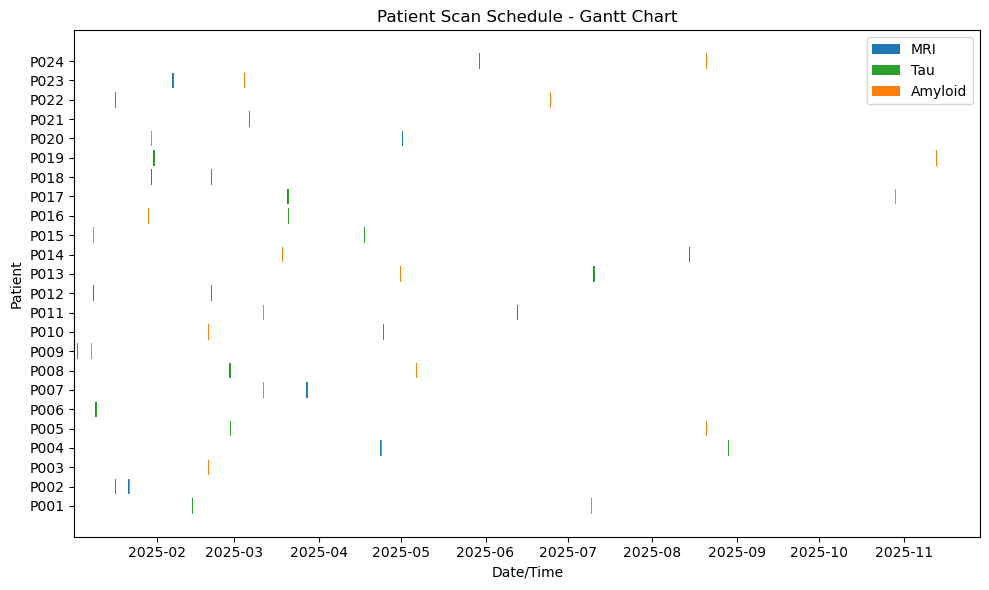

In [13]:
# Create Gnatt visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Map scan types to colors
colors = {"MRI": "tab:blue", "Amyloid": "tab:orange", "Tau": "tab:green"}

for i, p in enumerate(sorted(patients)):
    patient_scans = df_schedule[df_schedule["Patient"] == p]
    for _, row in patient_scans.iterrows():
        start = pd.to_datetime(f"{row['Date']} {row['Time']}")
        ax.barh(p, 0.3, left=start, color=colors[row["ScanType"]], label=row["ScanType"])

# Legend without duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_xlabel("Date/Time")
ax.set_ylabel("Patient")
ax.set_title("Patient Scan Schedule - Gantt Chart")
plt.tight_layout()
plt.savefig("gnatt_chart.png", dpi=300, bbox_inches='tight')
plt.show();

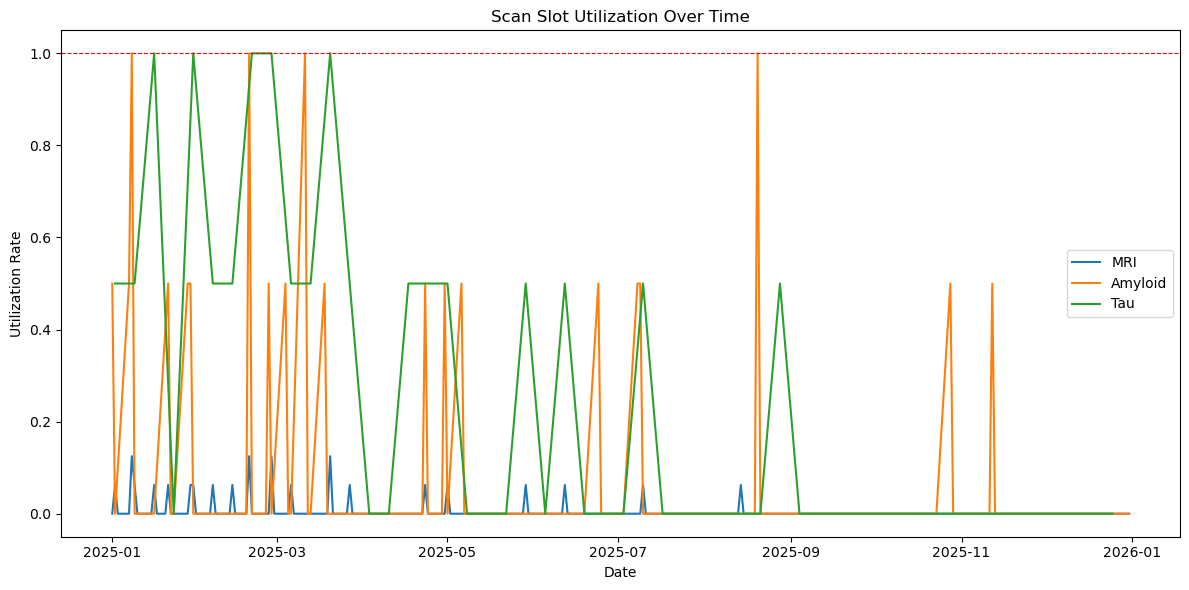

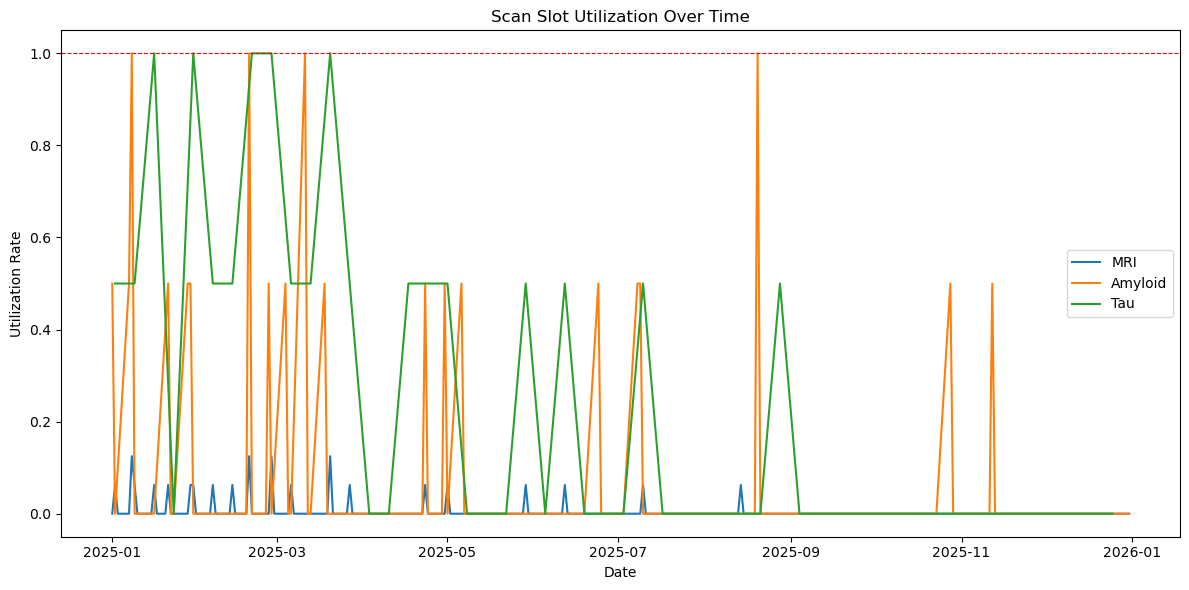

In [15]:
# Create a plot for scan utilization
utilization = df_schedule.groupby(["Date", "ScanType"]).size().reset_index(name="UsedSlots")

total_capacity = []
for s in scan_types:
    for d in scan_availability[s]["days"]:
        total_capacity.append({
            "Date": d,
            "ScanType": s,
            "TotalSlots": len(scan_availability[s]["slots"])
        })
df_capacity = pd.DataFrame(total_capacity)

df_util = pd.merge(df_capacity, utilization, how="left", on=["Date", "ScanType"]).fillna(0)
df_util["Utilization"] = df_util["UsedSlots"] / df_util["TotalSlots"]

# Plot utilization
plt.figure(figsize=(12, 6))
for s in scan_types:
    subset = df_util[df_util["ScanType"] == s]
    plt.plot(pd.to_datetime(subset["Date"]), subset["Utilization"], label=s)

plt.axhline(1, color="red", linestyle="--", linewidth=0.8)
plt.title("Scan Slot Utilization Over Time")
plt.xlabel("Date")
plt.ylabel("Utilization Rate")
plt.legend()
plt.tight_layout()
plt.savefig("scan_utilization.png", dpi=300, bbox_inches='tight')
plt.show();

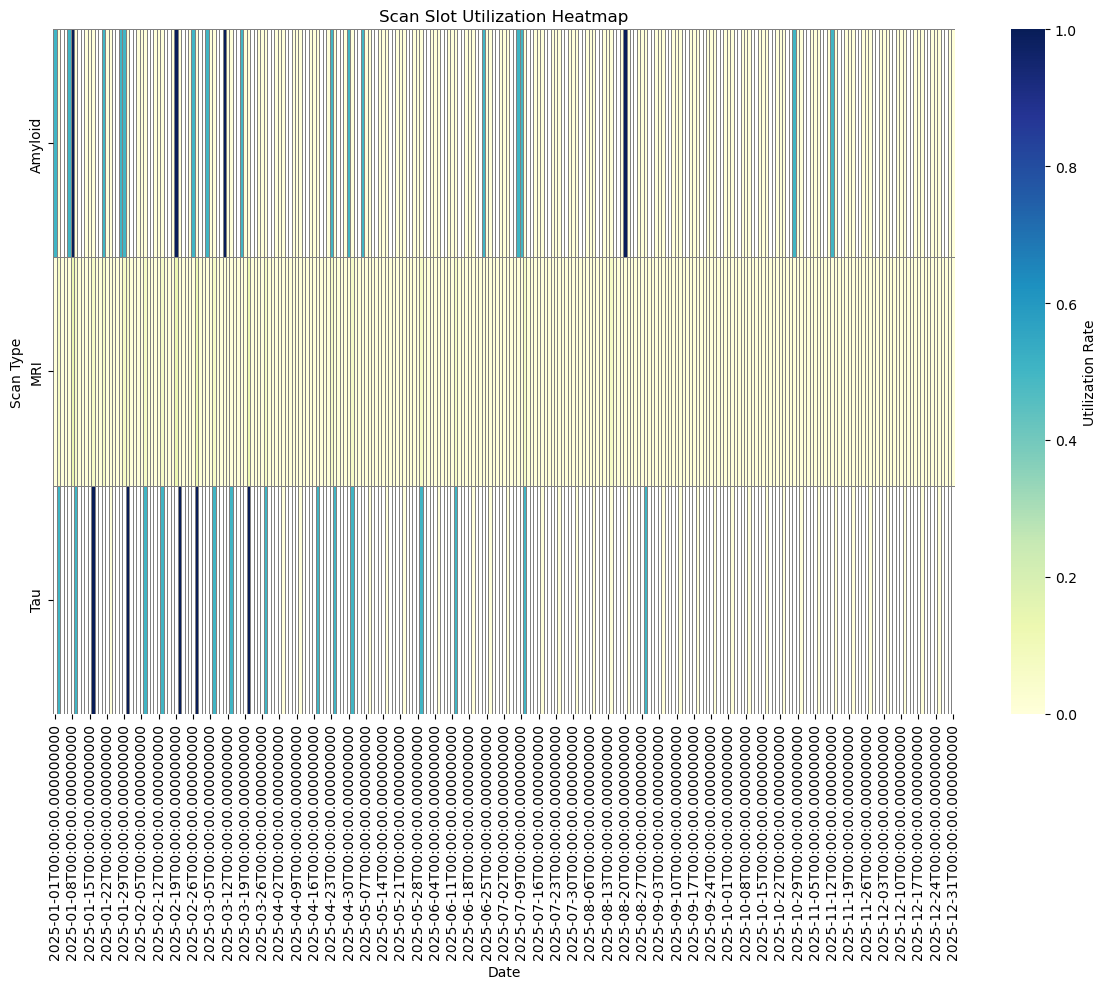

In [17]:
# Pivot the data to have Dates as rows, ScanType as columns, and Utilization as values
df_heatmap = df_util.pivot(index="Date", columns="ScanType", values="Utilization")

# Convert index to datetime for better plotting
df_heatmap.index = pd.to_datetime(df_heatmap.index)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    df_heatmap.T,  # transpose so scan types are rows
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Utilization Rate"},
    vmin=0,
    vmax=1
)
plt.title("Scan Slot Utilization Heatmap")
plt.xlabel("Date")
plt.ylabel("Scan Type")
plt.tight_layout()
plt.savefig("heatmap_utilization.png", dpi=300, bbox_inches='tight')
plt.show();

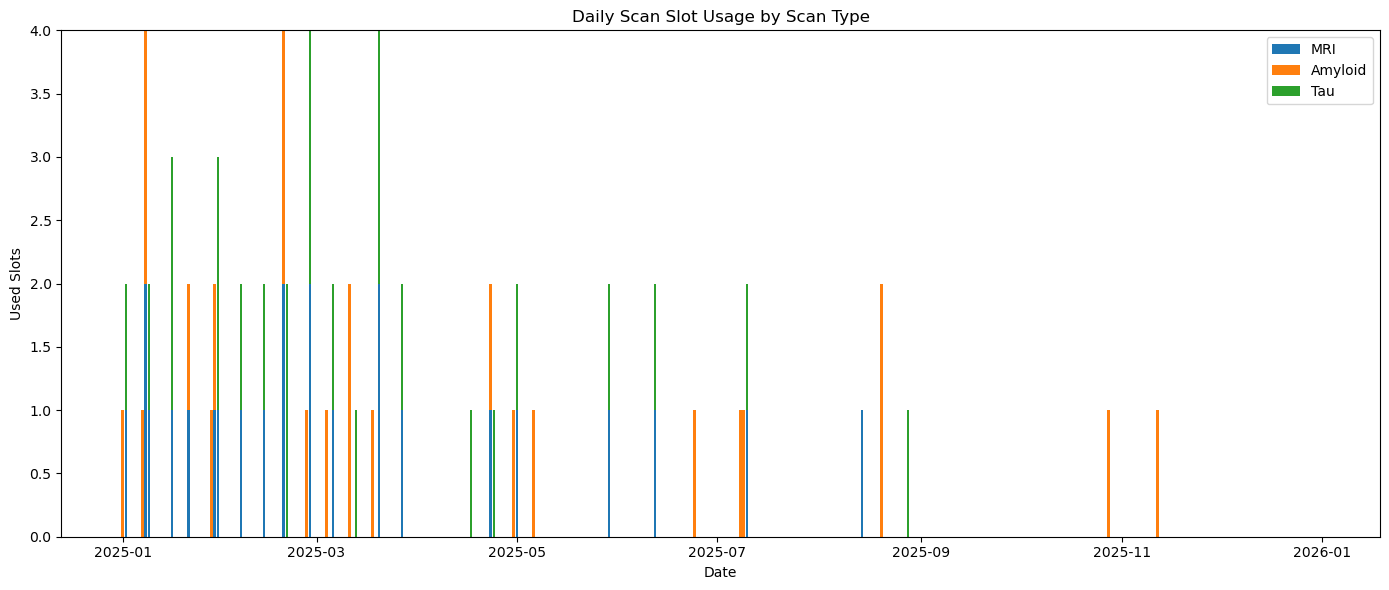

In [19]:
# Pivot data: rows = Date, columns = ScanType, values = UsedSlots
df_pivot = df_util.pivot(index="Date", columns="ScanType", values="UsedSlots").fillna(0)

# Plot stacked bar chart
plt.figure(figsize=(14, 6))
bottom = 0
colors = {"MRI": "tab:blue", "Amyloid": "tab:orange", "Tau": "tab:green"}

for s in scan_types:
    plt.bar(pd.to_datetime(df_pivot.index), df_pivot[s], bottom=bottom, color=colors[s], label=s)
    bottom += df_pivot[s]

plt.title("Daily Scan Slot Usage by Scan Type")
plt.xlabel("Date")
plt.ylabel("Used Slots")
plt.legend()
plt.tight_layout()
plt.savefig("daily_useage.png", dpi=300, bbox_inches='tight')
plt.show();